<a href="https://colab.research.google.com/github/younhuiji/openCV/blob/main/%5B2%5DU_NET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # << U-net >>

1. FCN(fully convolution network)의 하나이며, 이미지의 세그멘테이션(물체가 어디에 있는지)을 추정하기 위한 네트워크

2. 생물의학(biomedical)의 이미지의 세그멘테이션을 실시하기 위해 2015년에 발표
(논문 URL : https://arxiv.org/abs/1505.04597)

3. fully convolution networt(FCN) : 컨벌루션 레이어로 대체해서 사용, 모든 결합층을 컨벌루션층으로 치환하는 것

       3-1 입출력 화상 사이즈를 고정 사이즈로 통일하는 전처리가 불필요하며(CNN단점)  다양한 이미지 사이즈가 섞인
       데이터 세트에서 세그멘테이션이나 이미지 변환, 물체 검출 등의 Encoder-Decoder 네트워크를
       "원래의 이미지의 크기감 그대로" 컨벌루션 레이어 커널을 이용하여 학습할 수  있다.

       3-2 Encoder-Decoder 구조의 시맨틱 세그멘테이션 네트워크에서 후반의 Decoder는
       전치 컨벌루션 레이어 (Up-Convolution)가되어 학습 가능한 레이어가 구성된다.

       3-3. 시맨틱 세그멘테이션전용 모델

4. deconvolusion :  up sampling」

5. skip-conection :  컨벌루션을 행한 후, 특징 맵을 유지해 두고, 나중에 역컨볼루션을 하는 화상에 더해 주는 처리

6. Semantic Segmentaion : 대상 이미지에 대해 화소마다 독립적인 [의미적 클래스 식별 = 라벨 ]을 위해 영역마다 분할 한다.
        [FCN  -> SegNet -> U-Net ]

7. FCN : 저해상도 이미지 대상 ,  U-Net : 해상도 선택 없이 [동일한 이미지크기]로 밀도가 높은 픽셀별 클래스

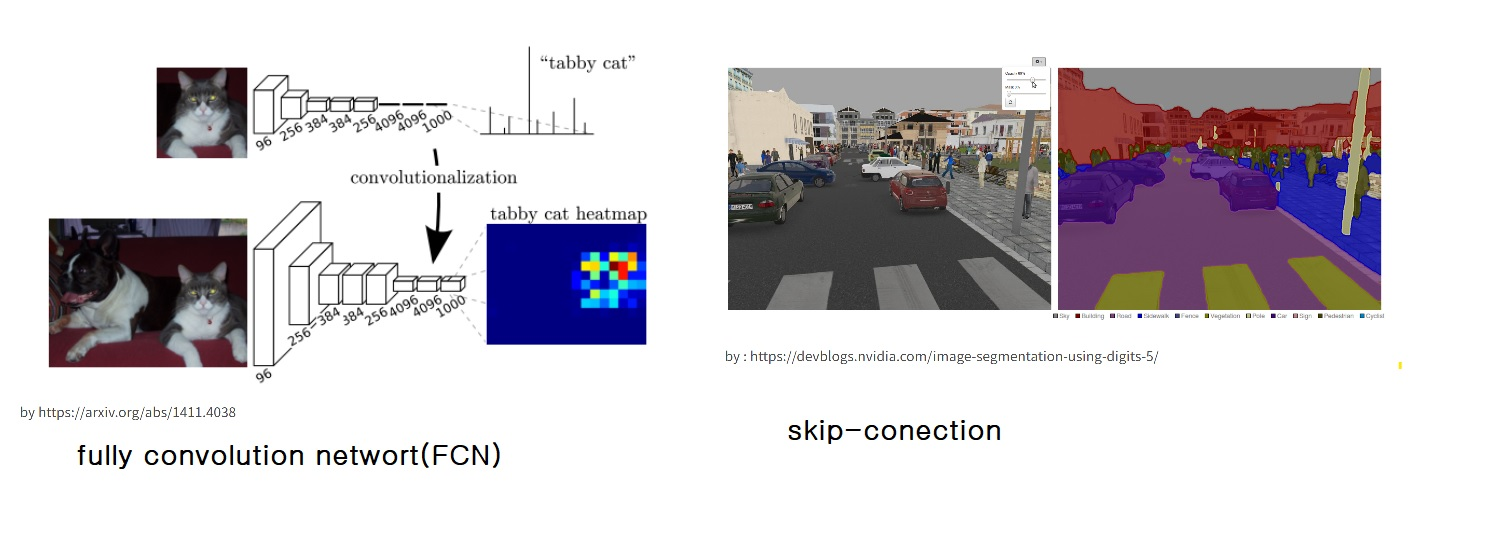


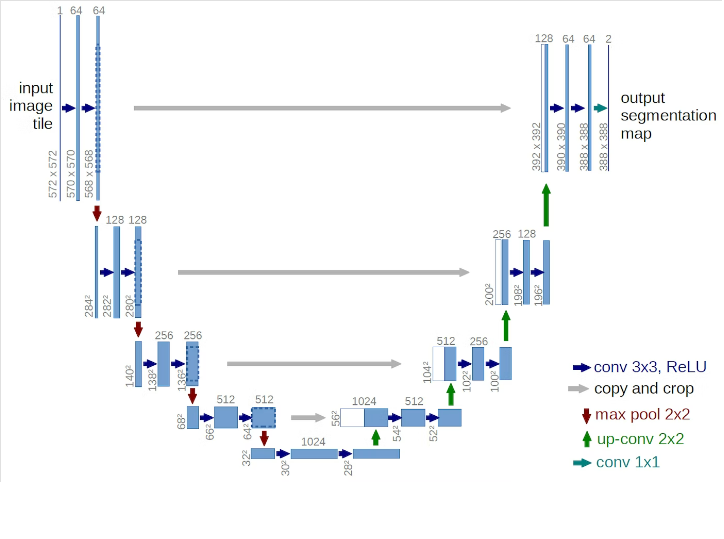

###  Convolutional Autoencoder  256→128→64→32 :  32→64→128→256
#### Cifar10의 데이터로 다음을 구성해 보자
    1. 간단한 컨벌루션 오토 엔코더
    2. 노이즈 제거 오토 엔코더
    3. UNET

#### Q1)  64→32→16으로 축소하고 디코더에서 16→32→64로 확대 ,간단한 컨벌루션 오토 엔코더

In [ ]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np

batch_size = 32
num_classes = 10
epochs = 5
saveDir = "/ae/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)


#1-1.로드 데이터
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#1-2 normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_val = x_test[:7000]
x_test = x_test[7000:]
print("validation data: {0} \ntest data: {1}".format(x_val.shape, x_test.shape))

170498071/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
validation data: (7000, 32, 32, 3) 
test data: (3000, 32, 32, 3)


In [ ]:
#1-3 Convolutional AutoEncoder

#################### encoded
input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)  # 활성화 이전에 선언
x = Activation('relu')(x)

x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

#################decoded
x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = UpSampling2D((2, 2))(x)

x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

model = Model(input_img, decoded) #AE
model.compile(optimizer='adam', loss='binary_crossentropy')


In [ ]:
#1-4 Train AutoEncoder
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = saveDir + 'AutoEncoder_Cifar10_Deep_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

#1-5모델 실행
history = model.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, x_val),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)


Epoch 1/5
1563/1563 [==============================] - ETA: 0s - loss: 0.5829
Epoch 1: val_loss improved from inf to 0.57557, saving model to /ae/AutoEncoder_Cifar10_Deep_weights.01-0.58-0.58.hdf5
1563/1563 [==============================] - 32s 11ms/step - loss: 0.5829 - val_loss: 0.5756
Epoch 2/5
   8/1563 [..............................] - ETA: 11s - loss: 0.5676

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1557/1563 [============================>.] - ETA: 0s - loss: 0.5724
Epoch 2: val_loss improved from 0.57557 to 0.57058, saving model to /ae/AutoEncoder_Cifar10_Deep_weights.02-0.57-0.57.hdf5
1563/1563 [==============================] - 13s 9ms/step - loss: 0.5724 - val_loss: 0.5706
Epoch 3/5
1559/1563 [============================>.] - ETA: 0s - loss: 0.5696
Epoch 3: val_loss improved from 0.57058 to 0.56938, saving model to /ae/AutoEncoder_Cifar10_Deep_weights.03-0.57-0.57.hdf5
1563/1563 [==============================] - 13s 9ms/step - loss: 0.5696 - val_loss: 0.5694
Epoch 4/5
1560/1563 [============================>.] - ETA: 0s - loss: 0.5682
Epoch 4: val_loss improved from 0.56938 to 0.56807, saving model to /ae/AutoEncoder_Cifar10_Deep_weights.04-0.57-0.57.hdf5
1563/1563 [==============================] - 13s 9ms/step - loss: 0.5681 - val_loss: 0.5681
Epoch 5/5
1563/1563 [==============================] - ETA: 0s - loss: 0.5673
Epoch 5: val_loss improved from 0.56807 to 0.56697, s

In [ ]:
#1-6 예측
c10test = model.predict(x_test)
c10val = model.predict(x_val)
print("Cifar10_test: {0}\nCifar10_val: {1}".format(np.average(c10test), np.average(c10val)))

219/219 [==============================] - 1s 4ms/step
Cifar10_test: 0.49134597182273865
Cifar10_val: 0.4947353005409241


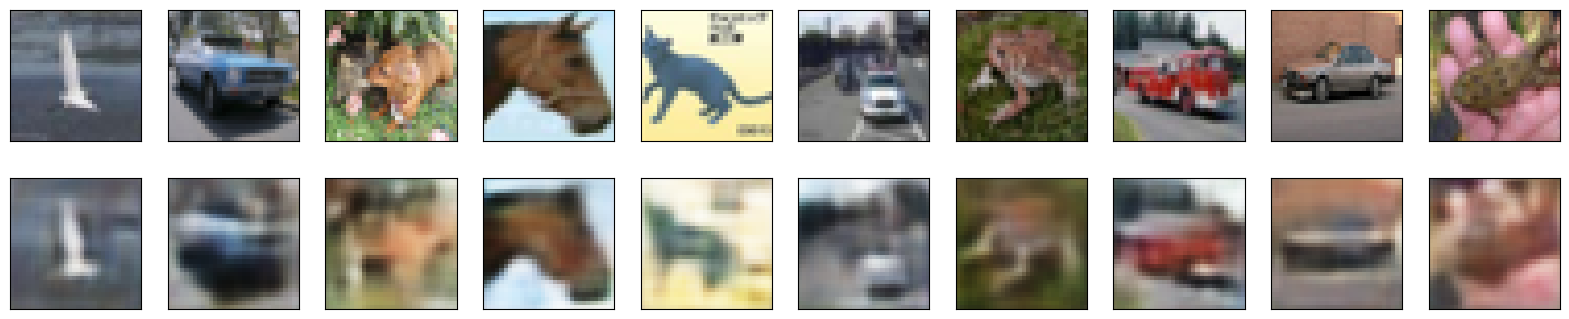

In [ ]:
#1-7 시각화
def show_img(orig, dec, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display 원본
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display 복원
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
show_img(x_test, c10test)

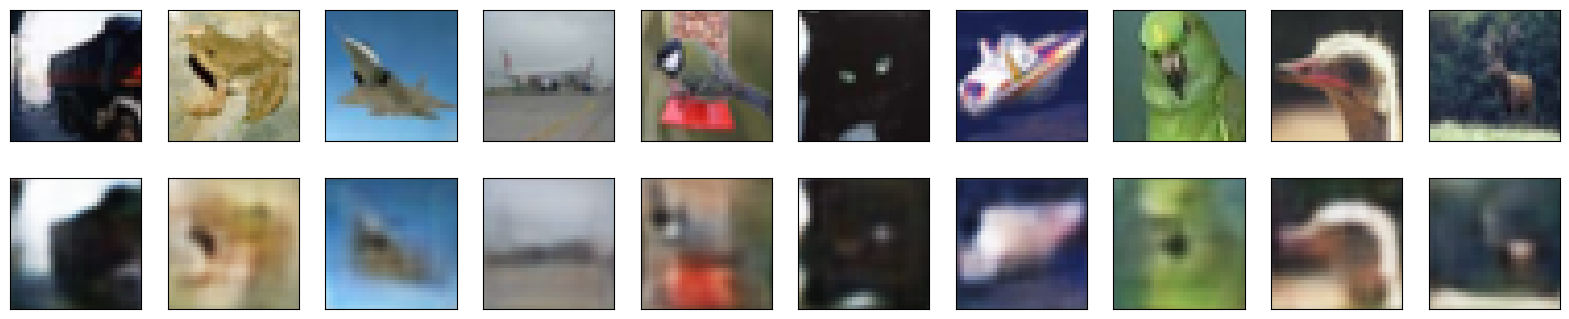

In [ ]:
show_img(x_test[100:], c10test[100:])

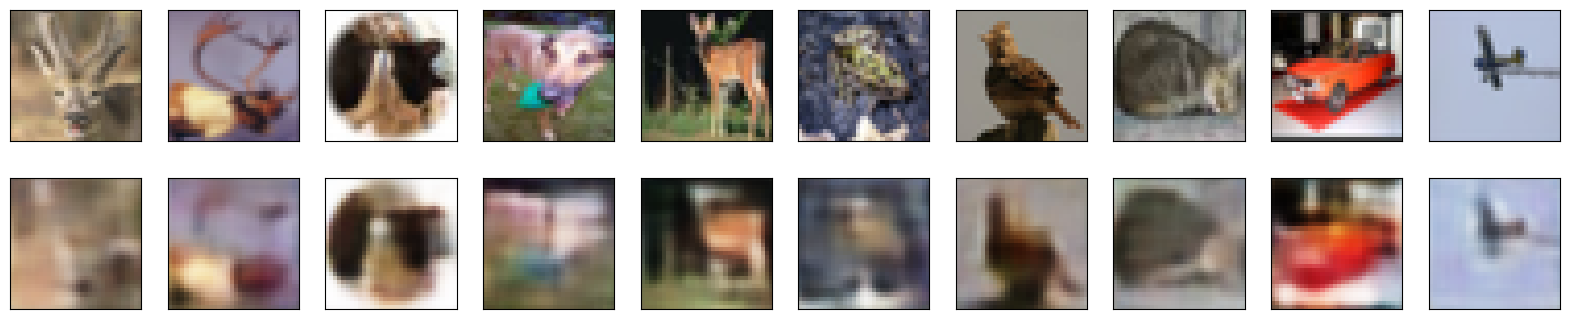

In [ ]:
show_img(x_test[200:], c10test[200:])

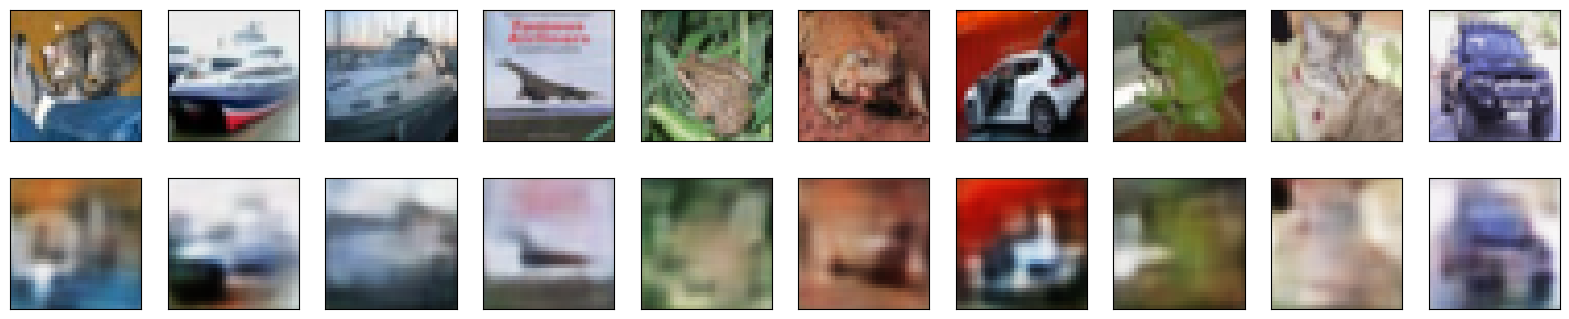

In [ ]:
show_img(x_val, c10val)

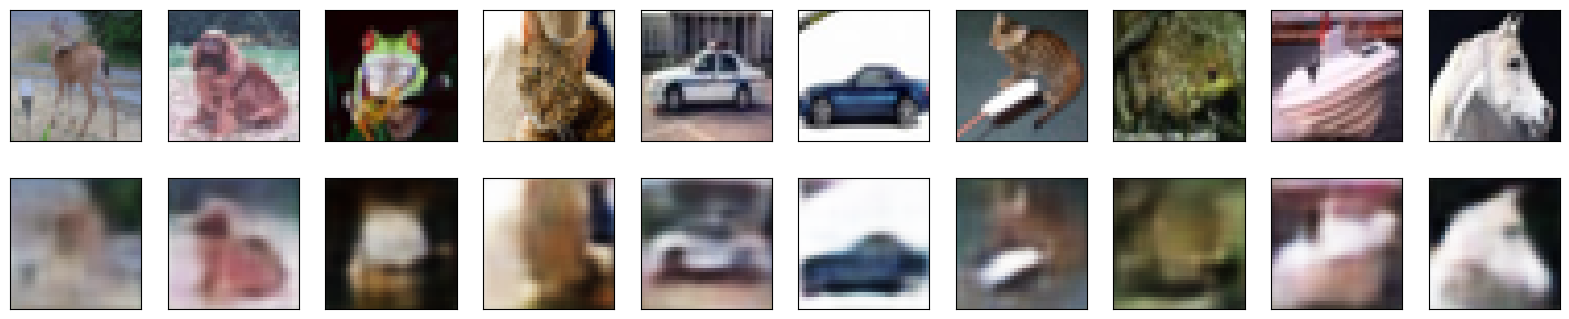

In [ ]:
show_img(x_val[100:], c10val[100:])

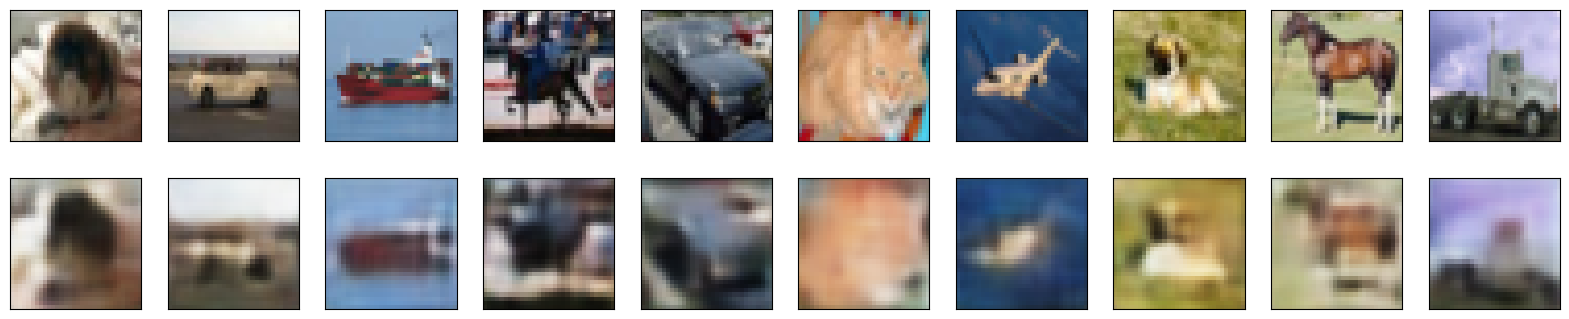

In [ ]:
show_img(x_val[200:], c10val[200:])

In [ ]:
import tensorflow as tf

model.save("my_model_unet_cifar10.h5")


loaded_model = tf.keras.models.load_model("my_model_unet_cifar10.h5")
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        18464 